In [1]:
import torch
import sys
sys.path.append('../')

from utils import batchify_ray, vis_density, ray_sampling
import numpy as np
import os
import torch

from data.transforms import build_transforms
from data.datasets import IBRDynamicDataset
from config import cfg
from data import make_data_loader, make_data_loader_view
from modeling import build_model

import matplotlib.pyplot as plt

In [2]:

'''
Sample rays from views (and images) with/without masks

--------------------------
INPUT Tensors
K: intrinsics of camera (3,3)
T: extrinsic of camera (4,4)
image_size: the size of image [H,W]

ROI:  2D ROI bboxes  (4) left up corner(x,y) followed the height and width  (h,w)

masks:(M,H,W)
-------------------
OUPUT:
list of rays:  (N,6)  dirs(3) + pos(3)
RGB:  (N,C)
'''

def render(model, K,T,img_size,ROI = None, bboxes = None,only_coarse = False,near_far=None):
    model.eval()
    assert not (bboxes is None and near_far is None), ' either bbox or near_far should not be None.'
    mask = torch.ones(img_size[0],img_size[1])
    if ROI is not None:
        mask = torch.zeros(img_size[0],img_size[1])
        mask[ROI[0]:ROI[0]+ROI[2], ROI[1]:ROI[1]+ROI[3]] = 1.0
    rays,_ = ray_sampling(K.unsqueeze(0), T.unsqueeze(0), img_size, masks=mask.unsqueeze(0))
    
    if near_far is not None:
        near_far = near_far.repeat(rays.size(0),1)
    
    if bboxes is not None:
        bboxes = bboxes.unsqueeze(0).repeat(rays.size(0),1,1)

    with torch.no_grad():
        stage2, stage1,_ = batchify_ray(model, rays, bboxes,near_far = near_far)


    rgb = torch.zeros(img_size[0],img_size[1], 3, device = stage2[0].device)
    rgb[mask>0.5,:] = stage2[0]

    depth = torch.zeros(img_size[0],img_size[1],1, device = stage2[1].device)
    depth[mask>0.5,:] = stage2[1]

    alpha = torch.zeros(img_size[0],img_size[1],1, device = stage2[2].device)
    alpha[mask>0.5,:] = stage2[2]
    
    stage2_final = [None]*3
    stage2_final[0] = rgb.reshape(img_size[0],img_size[1], 3)
    stage2_final[1] = depth.reshape(img_size[0],img_size[1])
    stage2_final[2] = alpha.reshape(img_size[0],img_size[1])


    rgb = torch.zeros(img_size[0],img_size[1], 3, device = stage1[0].device)
    rgb[mask>0.5,:] = stage1[0]

    depth = torch.zeros(img_size[0],img_size[1],1, device = stage1[1].device)
    depth[mask>0.5,:] = stage1[1]

    alpha = torch.zeros(img_size[0],img_size[1],1, device = stage1[2].device)
    alpha[mask>0.5,:] = stage1[2]

    stage1_final = [None]*3
    stage1_final[0] = rgb.reshape(img_size[0],img_size[1], 3)
    stage1_final[1] = depth.reshape(img_size[0],img_size[1])
    stage1_final[2] = alpha.reshape(img_size[0],img_size[1])

    return stage2_final, stage1_final

In [3]:
training_folder = '/data/sport/ori4depth800x800/'
epoch = 489000
para_file = 'rfnr_model_%d.pth' % epoch

In [5]:
cfg.merge_from_file(os.path.join(training_folder,'configs.yml'))
cfg.MODEL.BOARDER_WEIGHT = 1e-10
cfg.DATASETS.TRAIN = os.path.join(training_folder,'format')
cfg.freeze()

AttributeError: Attempted to set BOARDER_WEIGHT to 1e-10, but CfgNode is immutable

In [6]:
model = build_model(cfg).cuda()
model.load_state_dict(torch.load(os.path.join(training_folder,para_file),map_location='cpu'))
model.eval()
model.cuda()
pass

In [6]:
data_folder_path = '/data/sport_1_small/'
transforms = build_transforms(cfg, False)
NHR_dataset = IBRDynamicDataset(data_folder_path, 1, False, transforms, [1.0, 6.5, 0.8], skip_step = 1, random_noisy = 0, holes='None')

0 / 1
load 56 Ts, 56 Ks, 1 frame, 167585 vertices
dataset initialed. near: 1.228015  far: 8.118557


In [7]:
for i in range(len(NHR_dataset)):
    print(i)
    img, _, _, T, K, near_far,_ ,_= NHR_dataset.__getitem__(i)
    img = img.cuda()
    T = T.cuda()
    K = K.cuda()
    near_far = near_far.cuda()
    stage2, stage1 = render(model,K, T,img_size = (img.size(2), img.size(1)), near_far=near_far)
    depth = stage2[1]
    depth_img = depth.reshape( (img.size(2), img.size(1), 1) )
    depth_img = (depth_img-depth_img.min())/(depth_img.max()-depth_img.min())
    depth_np = np.array(depth_img.cpu())
    np.save('/data/sport_1_small/depth_new/depth{}'.format(i), depth_np)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


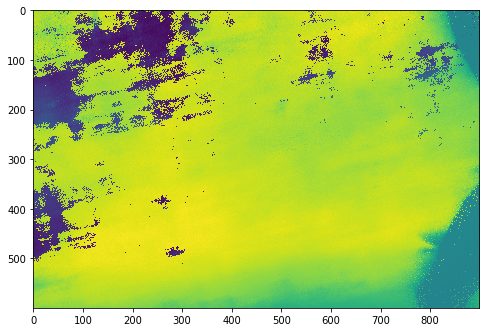

In [21]:
plt.figure(figsize=(8,6))
image = depth_img.cpu().numpy()[:,:,0]
plt.imshow(image)
plt.show()

In [8]:
import glob
depth_tensor = []
for depth in glob.glob('/data/sport_1_small/depth_new/*.npy'):
    depth_tensor.append(np.load(depth).reshape(-1))
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


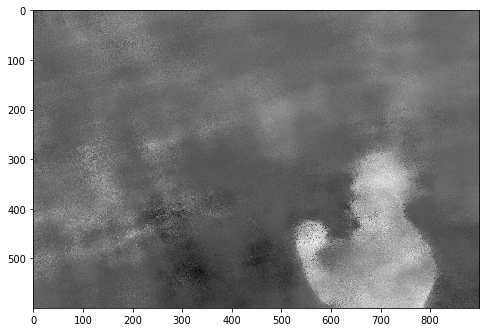

In [15]:
depth_tensor = torch.tensor(depth_tensor)
depth_img = depth_tensor.reshape(56,600,900,1)[15]

plt.figure(figsize=(8,6))
image = depth_img.cpu().numpy()[:,:,0]
plt.imshow(image,cmap=plt.cm.gray)
plt.show()